# Building Tree Clusters Pipeline

This code will build the supervised tree clusters to minimize distance between samples in each node. In order to run this code you will need to: 
1. Create your own pre_process function to read in your dataset and return the following dataframes: xTrain, xTest, yTrain, yTest, df_train, df_test (the last 2 are the full dataframes for training and testing) 
2. Run all cells below 
3. Call get_tree_clust(depth, pre_process_func) on the depth you want for your tree and the pre_process function that you just created. Your resulting tree will be printed and we will return the ROC AUC score for the tree and the resulting tree itself. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
# from numpy.random import randint
from numpy.random import rand
#import seaborn as sns
import scipy.stats as sc
# import shap
# import lime
import sklearn 
import warnings
#import xgboost
import itertools
import gc
import networkx as nx
import pydot
import re
import multiprocessing as mp
from itertools import product 
import time
import pickle 
#import interpret
import collections
import math
import random
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  RandomForestRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn import preprocessing
# from interpret.glassbox import ExplainableBoostingClassifier
# from interpret import show
from sklearn.preprocessing import LabelEncoder
# from interpret.glassbox import ExplainableBoostingRegressor
# from interpret import show
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import AdaBoostRegressor
%matplotlib inline
import os, sys
#import statsmodels.api as sm
sys.path.append(os.path.abspath("../../../"))

pd.set_option('display.max_columns', None)
import eli5
from eli5.sklearn import PermutationImportance

import sys
print(sys.path)

sys.path.append("/anaconda3/lib/python3.6/site-packages")
 

['/Users/aparnacalambur/Documents/Cornell/Classes/MEng/interpretable_clustering', '', '/Library/Python/3.6/site-packages', '/Users/aparnacalambur/Documents/Cornell/Classes/MEng/interpretable_clustering', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '/Users/aparnacalambur/Library/Python/3.7/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages', '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/extensions', '/Users/aparnacalambur/.ipython', '/Users/aparnacalambur/Documents/Cornell']


In [3]:
# preprocessing
def pre_process(ts=0.3):
    titanic = pd.read_csv('train.csv')
    #titanic
    full_data = titanic
    full_data = full_data.drop(['PassengerId'], axis=1)

    deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
    full_data['Cabin'] = full_data['Cabin'].fillna("U0")
    full_data['Deck'] = full_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    full_data['Deck'] = full_data['Deck'].map(deck)
    full_data['Deck'] = full_data['Deck'].fillna(0)
    full_data['Deck'] = full_data['Deck'].astype(int)

    full_data = full_data.drop('Cabin', axis = 1)

    mean = full_data["Age"].mean()
    std = full_data["Age"].std()
    is_null = full_data["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = full_data["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    full_data["Age"] = age_slice
    full_data["Age"] = full_data["Age"].astype(int)
    full_data["Age"].isnull().sum()
    full_data['Embarked'] = full_data['Embarked'].fillna('S')


    full_data['Fare'] = full_data['Fare'].fillna(0)
    full_data['Fare'] = full_data['Fare'].astype(int)
    full_data = full_data.drop(['Name'], axis=1)
    full_data = full_data.drop(['Ticket'], axis=1)
    full_data['Sex'] = full_data['Sex'].map({"male": 0, "female": 1})


    full_data_train,full_data_test = train_test_split(full_data,test_size = ts,random_state = 10)

    full_data = pd.get_dummies(full_data,columns = ['Pclass','Embarked','Deck'])
    full_data = full_data.dropna().reset_index().drop('index',axis = 1)
    X = full_data.drop('Survived',axis = 1)
    cols = X.columns
    y = full_data['Survived']
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    X =pd.DataFrame(X, columns = cols)
    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = ts,random_state = 10)
    full_data_train = full_data_train[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Deck"]]
    full_data_test = full_data_test[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Deck"]]
    return xTrain, xTest, yTrain, yTest, full_data_train, full_data_test


In [4]:
def pre_proc_synthetic_non_linear():
    n = 300
    X = np.random.randn(n, 10)
    y = -2 * np.sin(2*X[:,0]*X[:,2] ) + np.maximum(X[:,1], 0)  + np.exp(-X[:,3]) + np.random.randn(n)
    cols = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
    X = preprocessing.scale(X)
    y = preprocessing.scale(y)
    X = pd.DataFrame(X,columns = cols)
    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)
    c = ['y'] + cols
    full_data = pd.DataFrame(columns=c)
    full_data['y'] = y
    for col in cols:
        full_data[col] = X[col]
    
    full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)
    return xTrain, xTest, yTrain, yTest, full_data_train, full_data_test

In [5]:
def pre_processing_adult():
    income_data = pd.read_csv('adult.csv')
    inc_no_tar = income_data.drop(columns = ['income'])
    c = ['income'] + list(inc_no_tar.columns)
    data = pd.DataFrame(columns=c)
    for col in c:
        data[col] = income_data[col]
    income_data = data.copy()

    income_data['workclass']= income_data['workclass'].replace({"?":"Unknown"})
    income_data['native-country']= income_data['native-country'].replace({"?":"Unknown"})
    income_data = income_data.drop(['education', 'marital-status', 'fnlwgt'], axis=1)
    
    label_encoder = preprocessing.LabelEncoder()
    income_data['workclass']= label_encoder.fit_transform(income_data['workclass'])
    income_data['occupation']= label_encoder.fit_transform(income_data['occupation'])
    income_data['relationship']= label_encoder.fit_transform(income_data['relationship'])
    income_data['race']= label_encoder.fit_transform(income_data['race'])
    income_data['gender']= label_encoder.fit_transform(income_data['gender'])
    income_data['native-country']= label_encoder.fit_transform(income_data['native-country'])
    income_data['income']= label_encoder.fit_transform(income_data['income'])
    
    full_data = income_data.sample(n=1000, random_state=1)

    full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)

    full_data = full_data.dropna().reset_index().drop('index',axis = 1)
    X = full_data.drop('income',axis = 1)
    cols = X.columns
    y = full_data['income']
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    X =pd.DataFrame(X, columns = cols)
    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)
    return xTrain, xTest, yTrain, yTest, full_data_train,full_data_test  

In [6]:
def pre_processing_adult2():
    income_data = pd.read_csv('adult.csv')
    inc_no_tar = income_data.drop(columns = ['income'])
    c = ['income'] + list(inc_no_tar.columns)
    data = pd.DataFrame(columns=c)
    for col in c:
        data[col] = income_data[col]
    income_data = data.copy()

    income_data['workclass']= income_data['workclass'].replace({"?":"Unknown"})
    income_data['native-country']= income_data['native-country'].replace({"?":"Unknown"})
    income_data = income_data.drop(['education', 'marital-status', 'fnlwgt'], axis=1)
    
    label_encoder = preprocessing.LabelEncoder()
    income_data['workclass']= label_encoder.fit_transform(income_data['workclass'])
    income_data['occupation']= label_encoder.fit_transform(income_data['occupation'])
    income_data['relationship']= label_encoder.fit_transform(income_data['relationship'])
    income_data['race']= label_encoder.fit_transform(income_data['race'])
    income_data['gender']= label_encoder.fit_transform(income_data['gender'])
    income_data['native-country']= label_encoder.fit_transform(income_data['native-country'])
    income_data['income']= label_encoder.fit_transform(income_data['income'])
    
    full_data = income_data.sample(n=2500, random_state=1)

    full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)

    full_data = full_data.dropna().reset_index().drop('index',axis = 1)
    X = full_data.drop('income',axis = 1)
    cols = X.columns
    y = full_data['income']
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    X =pd.DataFrame(X, columns = cols)
    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)
    return xTrain, xTest, yTrain, yTest, full_data_train,full_data_test  

In [7]:
def pre_processing_adult3():
    income_data = pd.read_csv('adult.csv')
    inc_no_tar = income_data.drop(columns = ['income'])
    c = ['income'] + list(inc_no_tar.columns)
    data = pd.DataFrame(columns=c)
    for col in c:
        data[col] = income_data[col]
    income_data = data.copy()

    income_data['workclass']= income_data['workclass'].replace({"?":"Unknown"})
    income_data['native-country']= income_data['native-country'].replace({"?":"Unknown"})
    income_data = income_data.drop(['education', 'marital-status', 'fnlwgt'], axis=1)
    
    label_encoder = preprocessing.LabelEncoder()
    income_data['workclass']= label_encoder.fit_transform(income_data['workclass'])
    income_data['occupation']= label_encoder.fit_transform(income_data['occupation'])
    income_data['relationship']= label_encoder.fit_transform(income_data['relationship'])
    income_data['race']= label_encoder.fit_transform(income_data['race'])
    income_data['gender']= label_encoder.fit_transform(income_data['gender'])
    income_data['native-country']= label_encoder.fit_transform(income_data['native-country'])
    income_data['income']= label_encoder.fit_transform(income_data['income'])
    
    full_data = income_data.sample(n=5000, random_state=1)

    full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)

    full_data = full_data.dropna().reset_index().drop('index',axis = 1)
    X = full_data.drop('income',axis = 1)
    cols = X.columns
    y = full_data['income']
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    X =pd.DataFrame(X, columns = cols)
    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)
    return xTrain, xTest, yTrain, yTest, full_data_train,full_data_test  

In [8]:
def pre_processing_adult4():
    income_data = pd.read_csv('adult.csv')
    inc_no_tar = income_data.drop(columns = ['income'])
    c = ['income'] + list(inc_no_tar.columns)
    data = pd.DataFrame(columns=c)
    for col in c:
        data[col] = income_data[col]
    income_data = data.copy()

    income_data['workclass']= income_data['workclass'].replace({"?":"Unknown"})
    income_data['native-country']= income_data['native-country'].replace({"?":"Unknown"})
    income_data = income_data.drop(['education', 'marital-status', 'fnlwgt'], axis=1)
    
    label_encoder = preprocessing.LabelEncoder()
    income_data['workclass']= label_encoder.fit_transform(income_data['workclass'])
    income_data['occupation']= label_encoder.fit_transform(income_data['occupation'])
    income_data['relationship']= label_encoder.fit_transform(income_data['relationship'])
    income_data['race']= label_encoder.fit_transform(income_data['race'])
    income_data['gender']= label_encoder.fit_transform(income_data['gender'])
    income_data['native-country']= label_encoder.fit_transform(income_data['native-country'])
    income_data['income']= label_encoder.fit_transform(income_data['income'])
    
    full_data = income_data.sample(n=10000, random_state=1)

    full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)

    full_data = full_data.dropna().reset_index().drop('index',axis = 1)
    X = full_data.drop('income',axis = 1)
    cols = X.columns
    y = full_data['income']
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    X =pd.DataFrame(X, columns = cols)
    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)
    return xTrain, xTest, yTrain, yTest, full_data_train,full_data_test  

In [9]:
def pre_processing_adult5():
    income_data = pd.read_csv('adult.csv')
    inc_no_tar = income_data.drop(columns = ['income'])
    c = ['income'] + list(inc_no_tar.columns)
    data = pd.DataFrame(columns=c)
    for col in c:
        data[col] = income_data[col]
    income_data = data.copy()

    income_data['workclass']= income_data['workclass'].replace({"?":"Unknown"})
    income_data['native-country']= income_data['native-country'].replace({"?":"Unknown"})
    income_data = income_data.drop(['education', 'marital-status', 'fnlwgt'], axis=1)
    
    label_encoder = preprocessing.LabelEncoder()
    income_data['workclass']= label_encoder.fit_transform(income_data['workclass'])
    income_data['occupation']= label_encoder.fit_transform(income_data['occupation'])
    income_data['relationship']= label_encoder.fit_transform(income_data['relationship'])
    income_data['race']= label_encoder.fit_transform(income_data['race'])
    income_data['gender']= label_encoder.fit_transform(income_data['gender'])
    income_data['native-country']= label_encoder.fit_transform(income_data['native-country'])
    income_data['income']= label_encoder.fit_transform(income_data['income'])
    
    full_data = income_data.sample(n=20000, random_state=1)

    full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)

    full_data = full_data.dropna().reset_index().drop('index',axis = 1)
    X = full_data.drop('income',axis = 1)
    cols = X.columns
    y = full_data['income']
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    X =pd.DataFrame(X, columns = cols)
    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)
    return xTrain, xTest, yTrain, yTest, full_data_train,full_data_test  

In [10]:
def pre_processing_adult6():
    income_data = pd.read_csv('adult.csv')
    inc_no_tar = income_data.drop(columns = ['income'])
    c = ['income'] + list(inc_no_tar.columns)
    data = pd.DataFrame(columns=c)
    for col in c:
        data[col] = income_data[col]
    income_data = data.copy()

    income_data['workclass']= income_data['workclass'].replace({"?":"Unknown"})
    income_data['native-country']= income_data['native-country'].replace({"?":"Unknown"})
    income_data = income_data.drop(['education', 'marital-status', 'fnlwgt'], axis=1)
    
    label_encoder = preprocessing.LabelEncoder()
    income_data['workclass']= label_encoder.fit_transform(income_data['workclass'])
    income_data['occupation']= label_encoder.fit_transform(income_data['occupation'])
    income_data['relationship']= label_encoder.fit_transform(income_data['relationship'])
    income_data['race']= label_encoder.fit_transform(income_data['race'])
    income_data['gender']= label_encoder.fit_transform(income_data['gender'])
    income_data['native-country']= label_encoder.fit_transform(income_data['native-country'])
    income_data['income']= label_encoder.fit_transform(income_data['income'])
    
    full_data = income_data.sample(n=40000, random_state=1)

    full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)

    full_data = full_data.dropna().reset_index().drop('index',axis = 1)
    X = full_data.drop('income',axis = 1)
    cols = X.columns
    y = full_data['income']
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    X =pd.DataFrame(X, columns = cols)
    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)
    return xTrain, xTest, yTrain, yTest, full_data_train,full_data_test  

In [11]:
def pre_processing_heart():
    heart = pd.read_csv("heart.csv")
    #full_data = heart
    heart = pd.read_csv("heart.csv")
    heart_no_tar = heart.drop(columns = ['target'])
    c = ['target'] + list(heart_no_tar.columns)
    full_data = pd.DataFrame(columns=c)
    for col in c:
        full_data[col] = heart[col]

    full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)

    full_data = full_data.dropna().reset_index().drop('index',axis = 1)
    X = full_data.drop('target',axis = 1)
    cols = X.columns
    y = full_data['target']
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(X)
    X =pd.DataFrame(X, columns = cols)
    xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)
    return xTrain, xTest, yTrain, yTest, full_data_train,full_data_test  

In [12]:
def evaluate_score(row):
    if row[0]>=3:
        if row[1]>= 3 or row[10]<3:
            if row[8]<1:
                return 0
            if row[8]>=1 and row[8]<2:
                return 1
            if row[8]>=2:
                return 2
        if row[1]< 3 or row[10]>=3:
            if row[3]<= 1:
                return 3
            if row[3]> 1:
                return 4
    if row[0]<3:
        if row[2]<= 1:
            return 5
        if row[2]> 1:
            return 6

In [42]:
def pre_proc_syn():

    # seed random number generator
    # seed(1)
    # generate some integers
    rand_a = 7*rand(1000, 8)
    # print(rand_a[0])
    rand_b = 7*rand(1000, 2)
    # print(rand_b[0])
    X = np.concatenate((rand_a, rand_b), axis=1)
    vec=abs(X[:,1]-5*np.ones(len(X[:,1])))
    # vec=vec.astype(int)
    vec=np.array(vec)
    vec=np.reshape(vec, (len(X[:,1]),1))
    X = np.concatenate((X, vec), axis=1)
    vec8 = np.reshape(X[:,8], (len(X[:,8]),1))
    X = np.concatenate((X, vec8), axis=1)
    y=np.apply_along_axis(evaluate_score, 1, X)
    features = list(range(0, X.shape[1]))
    X = preprocessing.scale(X)
    y =  preprocessing.scale(y)
    X = pd.DataFrame(X,columns = features)
    xTrain, xTest, yTrain, yTest = sklearn.model_selection.train_test_split(X,y,test_size = .3)
    income_data = xTrain.copy()
    income_data['label'] = yTrain
    inc_no_tar = income_data.drop(columns = ['label'])
    c = ['label'] + list(inc_no_tar.columns)
    data = pd.DataFrame(columns=c)
    for col in c:
        data[col] = income_data[col]
    df_train = data.copy()
    income_data = xTest.copy()
    income_data['label'] = yTest
    inc_no_tar = income_data.drop(columns = ['label'])
    c = ['label'] + list(inc_no_tar.columns)
    data = pd.DataFrame(columns=c)
    for col in c:
        data[col] = income_data[col]
    df_test = data.copy()
    return xTrain, xTest, yTrain, yTest, df_train, df_test

In [47]:
def pre_proc_syn_nonlin():
    n = 300
    X = np.random.randn(n, 10)
    y = -2 * np.sin(2*X[:,0]*X[:,2] ) + np.maximum(X[:,1], 0)  + np.exp(-X[:,3]) + np.random.randn(n)
    cols = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
    X = preprocessing.scale(X)
    y = preprocessing.scale(y)
    X = pd.DataFrame(X,columns = cols)
    xTrain, xTest, yTrain, yTest = sklearn.model_selection.train_test_split(X,y,test_size = .3)
    income_data = xTrain.copy()
    income_data['label'] = yTrain
    inc_no_tar = income_data.drop(columns = ['label'])
    c = ['label'] + list(inc_no_tar.columns)
    data = pd.DataFrame(columns=c)
    for col in c:
        data[col] = income_data[col]
    df_train = data.copy()
    income_data = xTest.copy()
    income_data['label'] = yTest
    inc_no_tar = income_data.drop(columns = ['label'])
    c = ['label'] + list(inc_no_tar.columns)
    data = pd.DataFrame(columns=c)
    for col in c:
        data[col] = income_data[col]
    df_test = data.copy()
    return xTrain, xTest, yTrain, yTest, df_train, df_test
    

https://scikit-learn.org/dev/auto_examples/tree/plot_unveil_tree_structure.html

# Distance Calc

In [14]:
def floyd_warshall(distance):
    nV = len(distance)
    for k in range(nV):
        for i in range(nV):
            for j in range(nV):
                distance[i][j] = min(distance[i][j], distance[i][k] + distance[k][j])
                #n += 1
    return distance

In [15]:
def get_tree_dists(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    dists = np.empty((n_nodes,n_nodes)); dists.fill(10000)
    for i in range(len(children_left)):
        left_node_id = children_left[i]
        if left_node_id != -1:
            dists[i][left_node_id] = 1
            dists[left_node_id][i] = 1

    for i in range(len(children_right)):
        if children_right[i] != -1:
            dists[i][children_right[i]] = 1
            dists[children_right[i]][i] = 1
    
    return dists, n_nodes

In [16]:
def get_rep_nodes(xTrain,yTrain,xTest, md, num_trees, leaves):
    train = xTrain.copy()
    train['y'] = yTrain
    train1 = train.sample(n = len(train), replace = True) 
    train1=train1.dropna(how='any')
    yTrain1 = train1['y']
    xTrain1 = train1.drop('y',axis = 1)
    gc.collect()
    
    for i in range(num_trees):
        estimator = DecisionTreeRegressor(max_depth=md).fit(xTrain1,yTrain1)
        leaves_train = estimator.apply(xTrain)
        for i in range(len(leaves_train)):
            leaves[i].append(leaves_train[i])
    
    leaves = [tuple(i) for i in leaves]
    inds= [leaves.index(x) for x in set(leaves)]
    inds.sort()
    reps = [0]*(len(leaves))
    for i in range(len(leaves)):
        leaf_tup = leaves[i]
        for ind in inds:
            if leaf_tup == leaves[ind]:
                reps[i] = ind
    
    pairs = []
    for i in range(len(inds)):
        for j in range(i+1, len(inds)):
            pairs.append((inds[i], inds[j])) 
        
    return pairs, inds, reps

In [17]:
def build_tree_fw(xTrain,yTrain,xTest, md, pairs, inds):
    train = xTrain.copy()
    train['y'] = yTrain
    train1 = train.sample(n = len(train), replace = True) 
    train1=train1.dropna(how='any')
    yTrain1 = train1['y']
    xTrain1 = train1.drop('y',axis = 1)
    gc.collect()
    
    estimator = DecisionTreeRegressor(max_depth=md).fit(xTrain1,yTrain1)
    leaves_train = estimator.apply(xTrain1)
    graph, n = get_tree_dists(estimator)
    fw_dist = floyd_warshall(graph)
    
    i1_train = [i for i, _ in pairs]
    i2_train = [i for _, i in pairs]
    #print(fw_dist.shape)
    #print(leaves_train)
    train_dists = [fw_dist[leaves_train[i]][leaves_train[j]] for i, j in pairs]
    train_dist_df = pd.DataFrame(i1_train,columns=['i1'])
    train_dist_df['i2'] = i2_train
    train_dist_df['tree_dist'] = train_dists
    
    return([estimator,train_dist_df])

In [18]:
def fit_random_forest(xTrain,yTrain,num_trees,xTest, md, pairs, inds):
    i = 0
    mods = []
    train_dists = pd.DataFrame()
    while i <= num_trees:
        tree = build_tree_fw(xTrain,yTrain,xTest, md, pairs, inds)
        mods.append(tree[0])
        train_dists = train_dists.append(tree[1])
        i = i+1
        
    train_final_dist = train_dists.groupby(['i1','i2']).mean().reset_index()
    return(mods,train_final_dist)

In [19]:
def rf_predict(xTest,mods):
    pred = []
    for clf in mods:
        pred.append(clf.predict(xTest))
    pred = np.mean(pred,axis = 0)
    pred = [int(x) for x in pred>=0.5]
    return pred


# Model

In [29]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset, df):
    feature = df.columns[index]
    left, right = list(), list()
    indleft, indright = list(), list()
    left_df = df[df[feature] < value]
    right_df = df[df[feature] >= value]
    for i, row in enumerate(dataset):
        if row[index] < value:
            left.append(row)
            indleft.append(i)
        else:
            right.append(row)
            indright.append(i)
    #print(indleft)
    return left, right, indleft, indright, left_df, right_df
 
# Calculate the avg distance for a split dataset
def distance_index(indleft, indright, reps, train_final_dist_dct):
    left_len = len(indleft)
    right_len = len(indright)
    mean_left_dist = 0
    mean_right_dist = 0
    if left_len > 0:
        left_nodes_map = []
        for i in indleft:
            left_nodes_map.append(reps[i])
        left_reps = list(set(left_nodes_map))
        left_reps.sort()
        left_pairs = []
        for i in range(len(left_reps)):
            for j in range(i+1, len(left_reps)):
                left_pairs.append((left_reps[i], left_reps[j]))
        
        c = Counter(left_nodes_map)
        for pair in left_pairs:
            mean_left_dist += c[pair[0]] * c[pair[1]] * train_final_dist_dct[pair]
        
    if right_len > 0:
        right_nodes_map = []
        for i in indright:
            right_nodes_map.append(reps[i])
        right_reps = list(set(right_nodes_map))
        right_reps.sort()
        right_pairs = []
        for i in range(len(right_reps)):
            for j in range(i+1, len(right_reps)):
                right_pairs.append((right_reps[i], right_reps[j]))
        
        c = Counter(right_nodes_map)
        for pair in right_pairs:
            mean_right_dist += c[pair[0]] * c[pair[1]] * train_final_dist_dct[pair]

    
    left_avg = (mean_left_dist / left_len) * (left_len / (left_len + right_len)) if left_len > 0 else 0
    right_avg = (mean_right_dist / right_len) * (right_len / (left_len + right_len)) if right_len > 0 else 0
    
    return left_avg + right_avg

# Select the best split point for a dataset
def get_split(dataset, df, reps, train_final_dist_dct):
    class_values = list(set(row[0] for row in dataset))
    s = 0
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(1, len(dataset[0])):
        for row in dataset:
            s+= 1
            left, right, indleft, indright, left_df, right_df = test_split(index, row[index], dataset, df)
            groups = left, right, left_df, right_df
            dist = distance_index(indleft, indright, reps, train_final_dist_dct)
            if dist < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], dist, groups
    #print(s)
    return {'index':b_index, 'value':b_value, 'groups':b_groups}
# Create a terminal node value

def to_terminal(group):
    outcomes = [row[0] for row in group]
    return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth, reps, train_final_dist_dct):
    left, right, left_df, right_df = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        #print('here')
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left, left_df, reps, train_final_dist_dct)
        split(node['left'], max_depth, min_size, depth+1, reps, train_final_dist_dct)
    # process right child
    if len(right) <= min_size:
        #print('here')
        node['right'] = to_terminal(right)
    else:
        #print('here')
        node['right'] = get_split(right, right_df, reps, train_final_dist_dct)
        split(node['right'], max_depth, min_size, depth+1, reps, train_final_dist_dct)
# Build a decision tree
def build_tree(train, df, max_depth, min_size, reps, train_final_dist_dct):
    root = get_split(train, df, reps, train_final_dist_dct)
    split(root, max_depth, min_size, 1, reps, train_final_dist_dct)
    return root
 
# Print a decision tree
def print_tree(node, df, depth=0):
    if isinstance(node, dict):
        print('%s[%s < %.3f]' % ((depth*' ', (df.columns[node['index']]), node['value'])))
        print_tree(node['left'], df, depth+1)
        print_tree(node['right'], df, depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))
        
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [21]:
def get_pred_lst(tree_full, dataset_test):
    y_pred_dt = []
    for row in dataset_test:
        y_pred_dt.append(predict(tree_full, row))
    return y_pred_dt

# Testing Distance Calc
Defne your own pre_process() function to return the dataframes: xTrain, xTest, yTrain, yTest, df_train, and df_test

In [68]:
num_rows_lst = []
num_dim_lst = []
depth_lst = []
time_lst = []
num_nodes = []
#mean_nodes = []

In [69]:
preprocs = [pre_process(), pre_processing_heart(), pre_processing_adult(), pre_processing_adult2(), pre_processing_adult3(), pre_processing_adult4(), pre_processing_adult5(), pre_processing_adult6()]

In [70]:
for fn in preprocs:
    print("New Dataset")
    num_rows = fn[0].shape[0] + fn[1].shape[0]
    num_dim = fn[0].shape[1]
    
    for depth in range(1, 6):
        print("new depth")
        xTrain, xTest, yTrain, yTest, df_train, df_test = fn
        dataset_train = df_train.to_numpy()
        dataset_test = df_test.to_numpy()
        rep_nodes = [[] for _ in range(len(df_train))]
        start = time.time()
        pairs, inds, reps = get_rep_nodes(xTrain,yTrain,xTest, depth, 50, rep_nodes)
        mods,train_final_dist= fit_random_forest(xTrain,yTrain,50,xTest, depth, pairs, inds)
        end = time.time()
        num_nodes.append(len(inds))
        num_rows_lst.append(num_rows)
        num_dim_lst.append(num_dim)
        depth_lst.append(depth)
        time_lst.append(end - start)

New Dataset
new depth
new depth
new depth
new depth
new depth
New Dataset
new depth
new depth
new depth
new depth
new depth
New Dataset
new depth
new depth
new depth
new depth
new depth
New Dataset
new depth
new depth
new depth
new depth
new depth
New Dataset
new depth
new depth
new depth
new depth
new depth
New Dataset
new depth
new depth
new depth
new depth
new depth
New Dataset
new depth
new depth
new depth
new depth
new depth
New Dataset
new depth
new depth
new depth
new depth
new depth


In [25]:
df = pd.DataFrame(columns=['num_rows', 'num_cols', 'tree_depth', 'num_nodes', 'time'])
df['num_rows'] = num_rows_lst
df['num_cols'] = num_dim_lst
df['tree_depth'] = depth_lst
df['num_nodes'] = num_nodes
df['time'] = time_lst

In [26]:
df.to_csv('rep_nodes_data.csv')

# Testing Cluster Time

In [ ]:
# loop through the list of nodes to translate them into rep nodes
# count number of times each rep node appears 
# get a list of pairs of rep nodes  
# go through list of pairs, get count of each pair and multiply them together, multiply them to distance
# accumulate for each pair, divide by len of ind list 

In [20]:
xTrain, xTest, yTrain, yTest, df_train, df_test = pre_process()
dataset_train = df_train.to_numpy()
dataset_test = df_test.to_numpy()
leaves = [[] for _ in range(len(df_train))]
pairs, inds, reps = get_rep_nodes(xTrain,yTrain,xTest, 5, 50, leaves)
mods,train_final_dist= fit_random_forest(xTrain,yTrain,50,xTest, 5, pairs, inds)
subset = train_final_dist[['i1', 'i2']]
tuples = [tuple(x) for x in subset.to_numpy()]
dist = dict(zip(tuples, train_final_dist['tree_dist'])) 
#build_tree(dataset_train, df_train, 4, 10, reps, dist)
start = time.time()
t = build_tree(dataset_train, df_train, 5, 30, reps, dist)
end = time.time()
print(end - start)

# Graphs

In [57]:
for i in range(11, 31):
    print(i)
    xTrain, xTest, yTrain, yTest, df_train, df_test = pre_proc_syn()
    dataset_train = df_train.to_numpy()
    dataset_test = df_test.to_numpy()
    leaves = [[] for _ in range(len(df_train))]
    pairs, inds, reps = get_rep_nodes(xTrain,yTrain,xTest, 5, 20, leaves)
    mods,train_final_dist= fit_random_forest(xTrain,yTrain,20,xTest, 5, pairs, inds)
    subset = train_final_dist[['i1', 'i2']]
    tuples = [tuple(x) for x in subset.to_numpy()]
    dist = dict(zip(tuples, train_final_dist['tree_dist']))
    t = build_tree(dataset_train, df_train, 5, 30, reps, dist)
    y_pred_dt = get_pred_lst(t, dataset_test)
    mse_tree_clust.append(mean_squared_error(yTest, y_pred_dt))

    clf = DecisionTreeRegressor(max_depth=5, min_samples_split= 30, random_state=0)
    clf.fit(xTrain, yTrain)
    yPred = clf.predict(xTest)
    mse_dt.append(mean_squared_error(yTest,yPred))
        
        
        

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


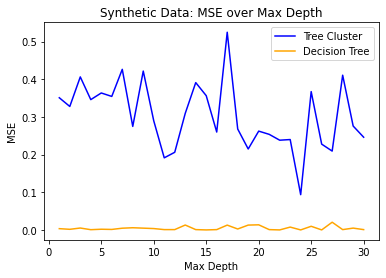

In [59]:
x_lst = [i for i in range(1, 31)]
plt.plot(x_lst, mse_tree_clust, color='blue', label="Tree Cluster")
plt.plot(x_lst, mse_dt, color='orange', label="Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("MSE")
plt.title("Synthetic Data: MSE over Max Depth")
plt.legend()
plt.show()

In [60]:

for i in range(11, 31):
    print(i)

    xTrain, xTest, yTrain, yTest, df_train, df_test = pre_proc_syn_nonlin()
    dataset_train = df_train.to_numpy()
    dataset_test = df_test.to_numpy()
    leaves = [[] for _ in range(len(df_train))]
    pairs, inds, reps = get_rep_nodes(xTrain,yTrain,xTest, 5, 20, leaves)
    mods,train_final_dist= fit_random_forest(xTrain,yTrain,20,xTest, 5, pairs, inds)
    subset = train_final_dist[['i1', 'i2']]
    tuples = [tuple(x) for x in subset.to_numpy()]
    dist = dict(zip(tuples, train_final_dist['tree_dist']))
    t = build_tree(dataset_train, df_train, 5, 30, reps, dist)
    y_pred_dt = get_pred_lst(t, dataset_test)
    mse_tree_clust_non_lin.append(mean_squared_error(yTest, y_pred_dt))

    clf = DecisionTreeRegressor(max_depth=5, min_samples_split= 30, random_state=0)
    clf.fit(xTrain, yTrain)
    yPred = clf.predict(xTest)
    mse_dt_non_lin.append(mean_squared_error(yTest,yPred))
        
        

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


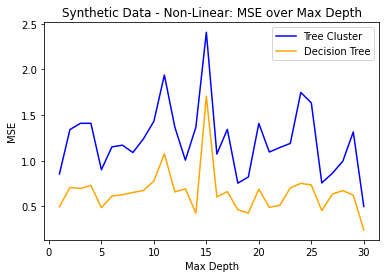

In [61]:
plt.plot(x_lst, mse_tree_clust_non_lin, color='blue', label="Tree Cluster")
plt.plot(x_lst, mse_dt_non_lin, color='orange', label="Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("MSE")
plt.title("Synthetic Data - Non-Linear: MSE over Max Depth")
plt.legend()
plt.show()

1
2
3
4
5
6
7
8
9
10


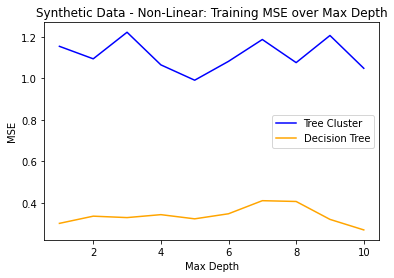

In [54]:
mse_tree_clust_non_lin_tr = []
mse_dt_non_lin_tr = []
for i in range(1, 11):
    print(i)
    mse_tree_clust_i = []
    mse_dt_i = []
    for j in range(5):
        xTrain, xTest, yTrain, yTest, df_train, df_test = pre_proc_syn_nonlin()
        dataset_train = df_train.to_numpy()
        dataset_test = df_test.to_numpy()
        leaves = [[] for _ in range(len(df_train))]
        pairs, inds, reps = get_rep_nodes(xTrain,yTrain,xTest, 5, 20, leaves)
        mods,train_final_dist= fit_random_forest(xTrain,yTrain,20,xTest, 5, pairs, inds)
        subset = train_final_dist[['i1', 'i2']]
        tuples = [tuple(x) for x in subset.to_numpy()]
        dist = dict(zip(tuples, train_final_dist['tree_dist']))
        t = build_tree(dataset_train, df_train, 5, 30, reps, dist)
        y_pred_dt = get_pred_lst(t, dataset_train)
        mse_tree_clust_i.append(mean_squared_error(yTrain, y_pred_dt))
        
        clf = DecisionTreeRegressor(max_depth=5, min_samples_split= 30, random_state=0)
        clf.fit(xTrain, yTrain)
        yPred = clf.predict(xTrain)
        mse_dt_i.append(mean_squared_error(yTrain,yPred))
    mse_tree_clust_non_lin_tr.append(sum(mse_tree_clust_i)/len(mse_tree_clust_i))
    mse_dt_non_lin_tr.append(sum(mse_dt_i)/len(mse_dt_i))
        
plt.plot(x_lst, mse_tree_clust_non_lin_tr, color='blue', label="Tree Cluster")
plt.plot(x_lst, mse_dt_non_lin_tr, color='orange', label="Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("MSE")
plt.title("Synthetic Data - Non-Linear: Training MSE over Max Depth")
plt.legend()
plt.show()    
        